# Predicting Shopping Trends

The goal of this project is to take ChatGPT generated data and to practice gathering useful information by implementing common ML algorithms. This data set can be found on Kaggle.

## Initial Setup

In [38]:
import numpy as np
import pandas as pd
import random

# Tools for visualizing the data
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Preprocessing Tools
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder, Normalizer, StandardScaler

# Pipeline testing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import svm

# Model Metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from sklearn.metrics import PredictionErrorDisplay

## Data

In [2]:
shoppingTrends = pd.read_csv(r'C:\Users\Tristan\Documents\Data Science Seminar\testdata.csv')

In [3]:
shoppingTrends

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3896,40,Female,Hoodie,Clothing,28,Virginia,L,Turquoise,Summer,4.2,No,2-Day Shipping,No,No,32,Venmo,Weekly
3896,3897,52,Female,Backpack,Accessories,49,Iowa,L,White,Spring,4.5,No,Store Pickup,No,No,41,Bank Transfer,Bi-Weekly
3897,3898,46,Female,Belt,Accessories,33,New Jersey,L,Green,Spring,2.9,No,Standard,No,No,24,Venmo,Quarterly
3898,3899,44,Female,Shoes,Footwear,77,Minnesota,S,Brown,Summer,3.8,No,Express,No,No,24,Venmo,Weekly


In [45]:
feature_list = ['Age',
                'Gender',
                'Item Purchased',
                'Category',
                'Location',
                'Size',
                'Color',
                'Season',
                'Review Rating',
                'Subscription Status',
                'Shipping Type',
                'Discount Applied',
                'Promo Code Used',
                'Previous Purchases',
                'Payment Method',
                'Frequency of Purchases']
numerical_list = ['Age',
                  'Review Rating',
                  'Previous Purchases']

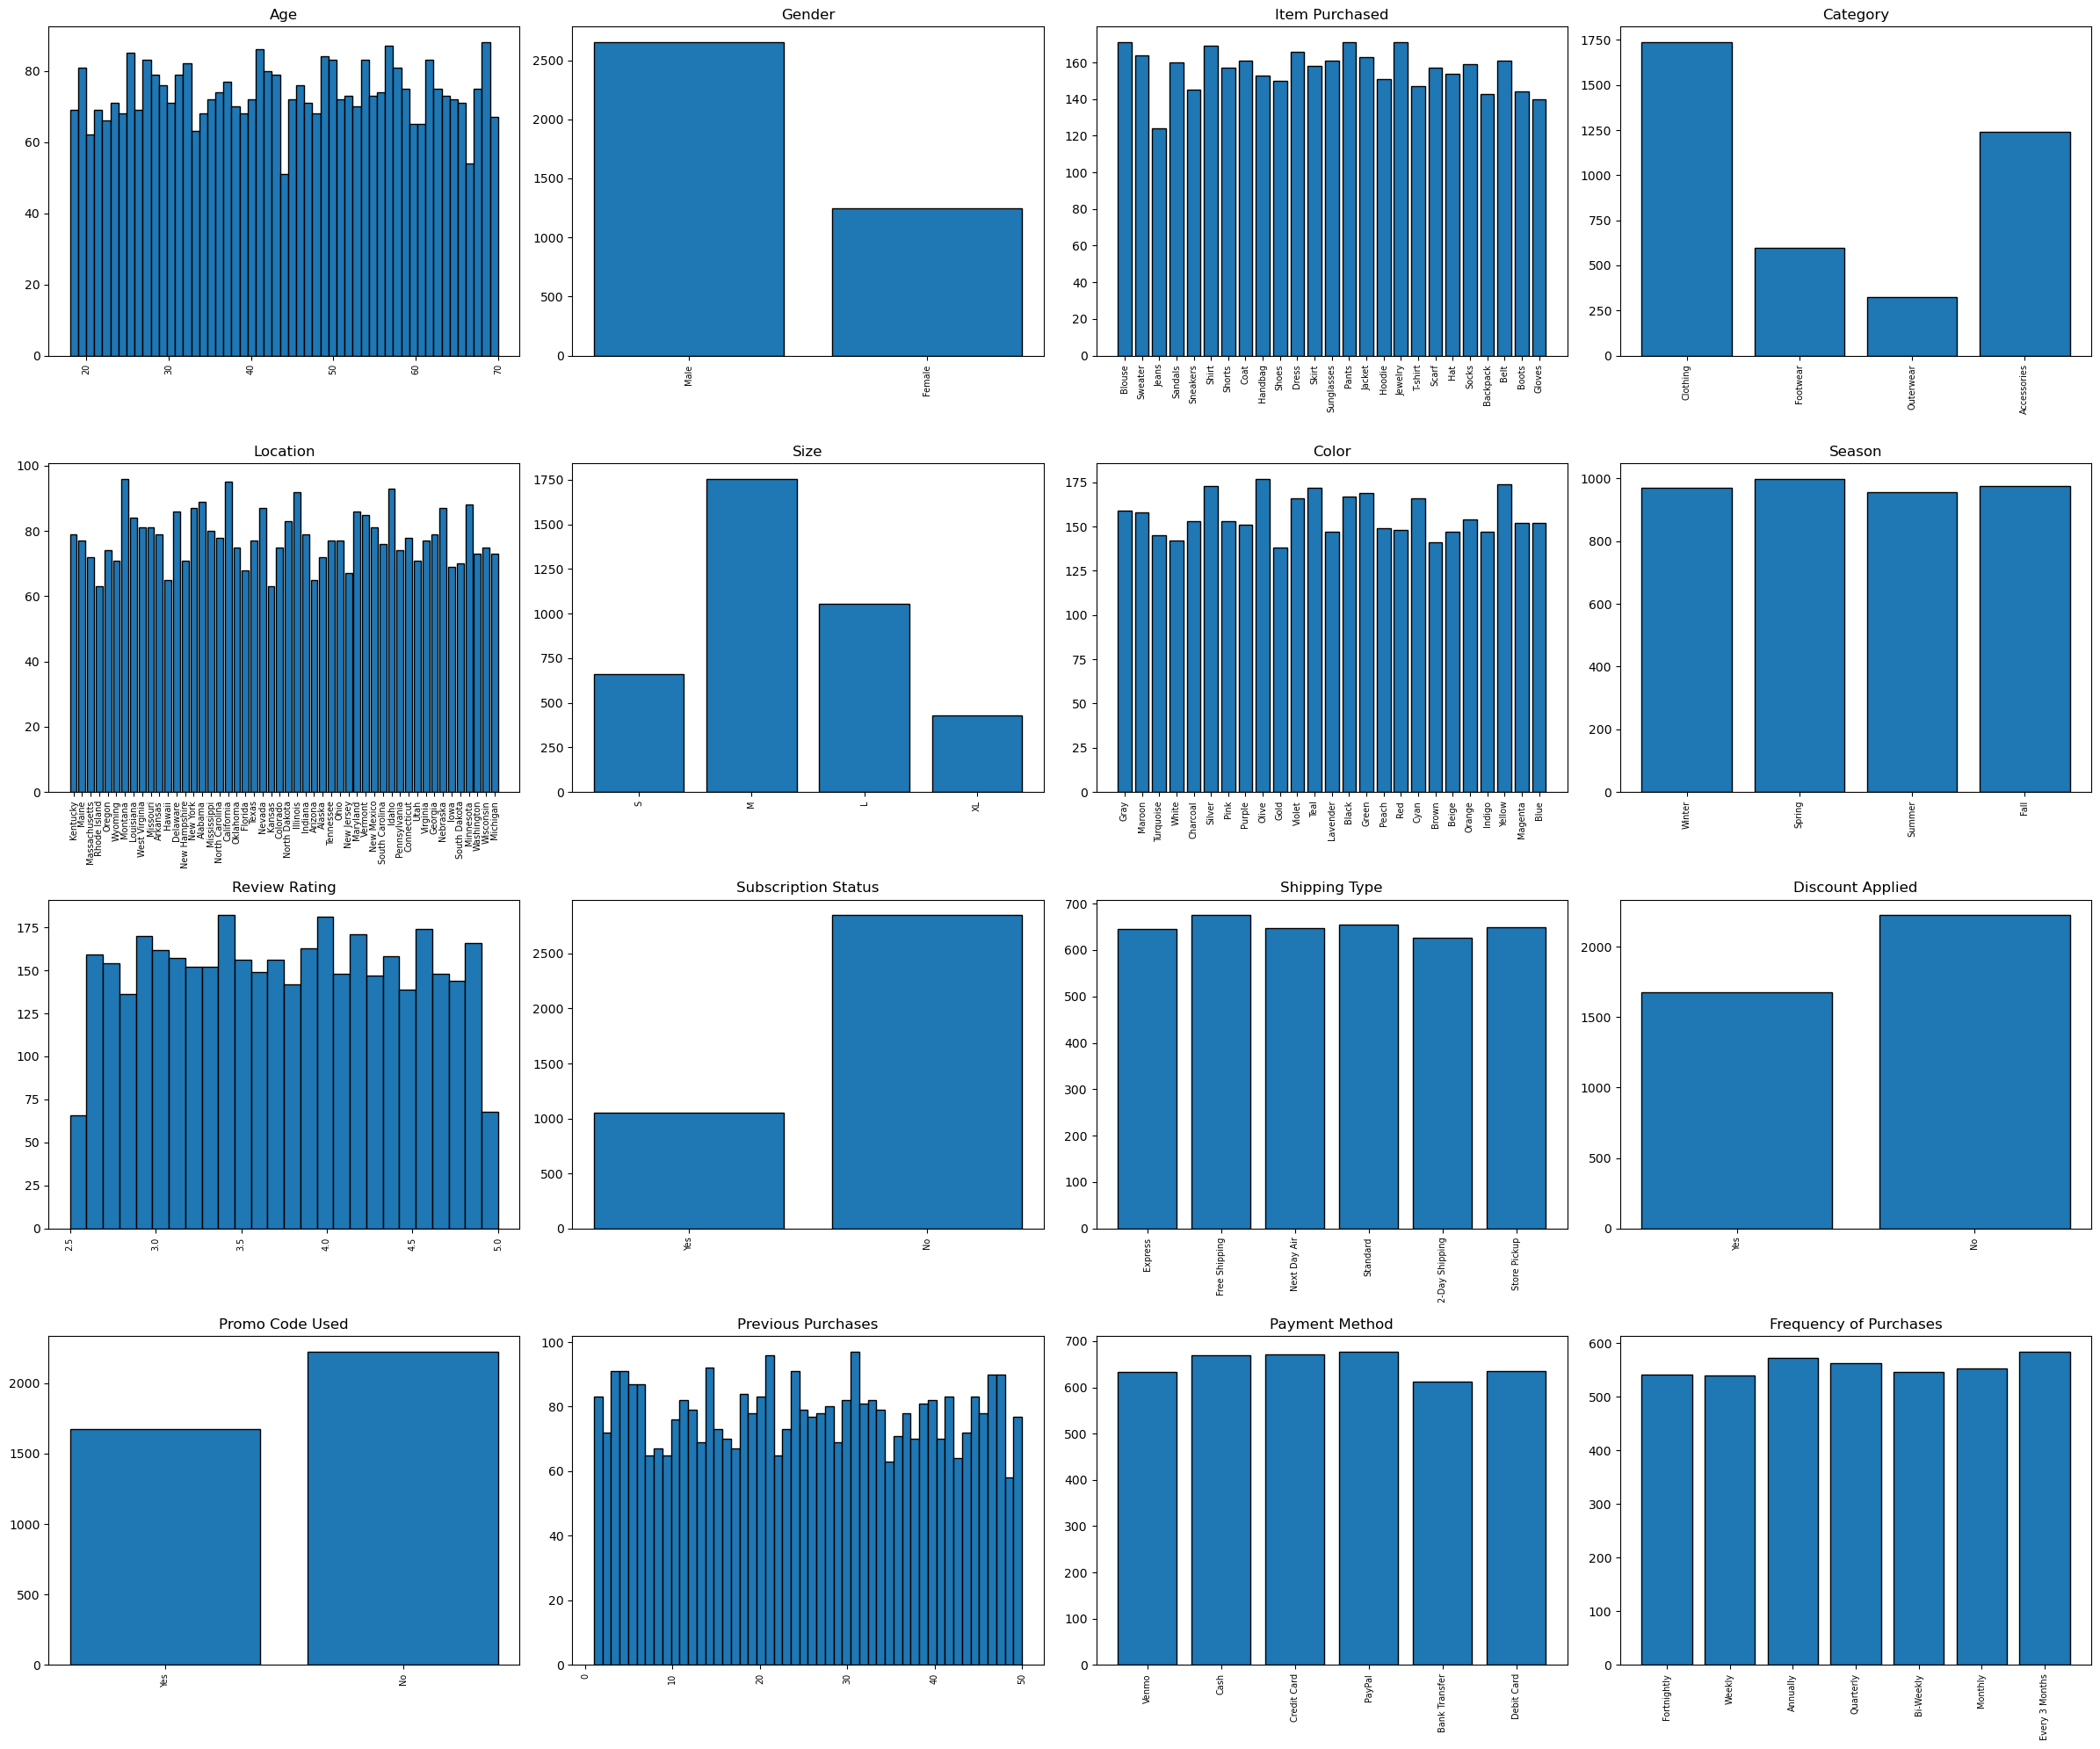

In [5]:
# Features we are interested in for plotting
feature_columns = shoppingTrends[feature_list]

# Plotting histograms / bar graphs to spot obvious ratios in data
plt.figure(figsize = (24,20))
for i, col_name in enumerate(feature_columns.columns.to_list()):
    plt.subplot(4,4,i+1)
    
    if col_name in numerical_list:
        nbins = feature_columns[col_name].unique().size
        plt.hist(feature_columns[col_name], label = col_name, bins = nbins, edgecolor = 'black')
        plt.xticks(rotation = 'vertical', fontsize = 7)
    elif col_name == 'Size':
        sizes = ['S','M','L','XL']
        mapping = {size: i for i,size in enumerate(sizes)}
        key = feature_columns[col_name].map(mapping)
        
        freqs = Counter(feature_columns[col_name].iloc[key.argsort()])
        xvals = range(len(freqs.values()))
        plt.bar(xvals, freqs.values(), edgecolor = 'black')
        plt.xticks(xvals,freqs.keys(),rotation = 'vertical',fontsize = 7)
    else:
        freqs = Counter(feature_columns[col_name])
        xvals = range(len(freqs.values()))
        plt.bar(xvals, freqs.values(), edgecolor = 'black')
        plt.xticks(xvals,freqs.keys(),rotation = 'vertical',fontsize = 7)
    
    plt.title(col_name)
    plt.tight_layout()

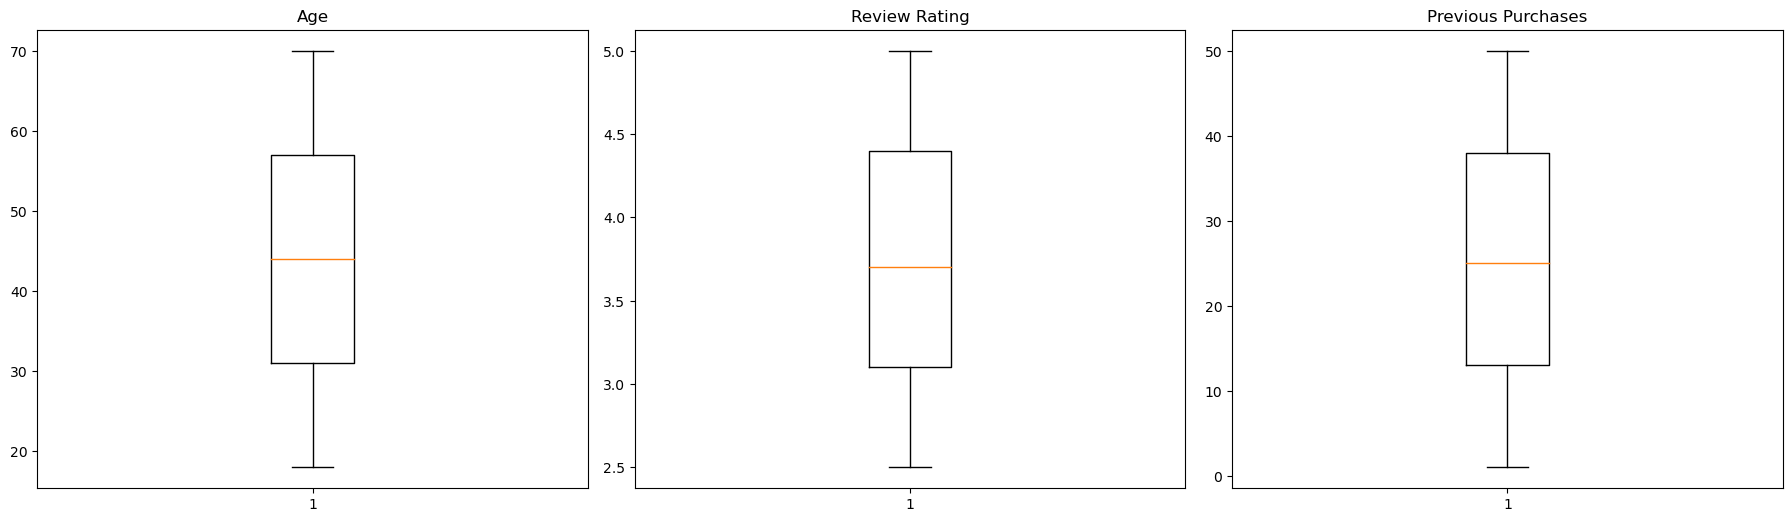

In [6]:
numerical_columns = shoppingTrends[numerical_list]

# Looking for outliers in our numerical features
plt.figure(figsize = (24,20))
for i, col_name in enumerate(numerical_columns.columns.to_list()):
    plt.subplot(4,4,i+1)
    plt.boxplot(numerical_columns[col_name])
    plt.title(col_name)
    plt.tight_layout()

Text(0.5, 0, 'Purchase Amount (USD)')

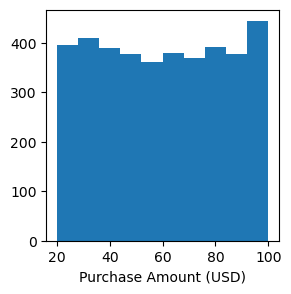

In [7]:
# Plotting the distribution of Purchase Amount (USD)
plt.figure(figsize = (3,3))
plt.hist(shoppingTrends['Purchase Amount (USD)'])
plt.xlabel('Purchase Amount (USD)')

This plot show that there is almost a uniform distribution of the amount of money spent in our dataset

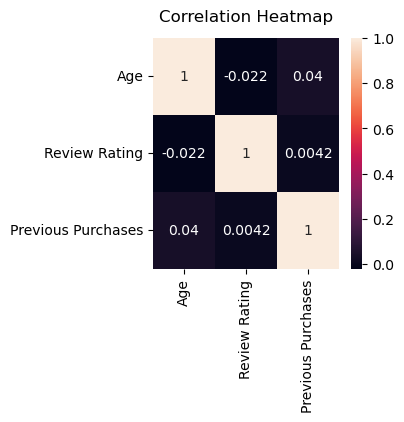

In [8]:
# Looking for relationships among numerical columns
plt.figure(figsize = (3,3))
heatmap = sns.heatmap(shoppingTrends[numerical_list].corr(), annot = True)
heatmap.set_title('Correlation Heatmap', fontdict = {'fontsize':12}, pad = 12);

## Pipeline

In [9]:
# Seed for reproducing outcomes

RANDOM_STATE = 4
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

In [67]:
# Separating data columns into our input features and label

# Separating numerical and categorical data
cat_feats = shoppingTrends.select_dtypes(include = 'object')
num_feats = shoppingTrends.select_dtypes(exclude = 'object')

num_list = list(set(num_feats)-set(['Purchase Amount (USD)']))

feature_list2 = ['Age',
                'Gender',
                'Item Purchased',
                'Category',
                'Location',
                'Size',
                'Color',
                'Season',
                'Review Rating',
                'Subscription Status',
                'Shipping Type',
                'Discount Applied',
                'Promo Code Used',
                'Previous Purchases',
                'Payment Method',
                'Frequency of Purchases',
                ]

X = shoppingTrends[feature_list2]
y = shoppingTrends['Purchase Amount (USD)']

# Listing categorical data by type of encoding needed
target_list = ['Item Purchased',
               'Location',
              'Color']
ord_list = ['Size',
               'Frequency of Purchases']
ohe_list = list(set(feature_list)-set(target_list)-set(ord_list)-set(['Age','Previous Purchases','Review Rating']))

In [47]:
numerical_list

['Age', 'Review Rating', 'Previous Purchases']

In [68]:
# We separate into training and testing data
# We do not stratify as we saw a near uniform distribution in our label variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RANDOM_STATE)

In [24]:
# Define the scaler step of our pipeline

scaler = Normalizer()

In [29]:
# Define machine learning models to be used

# Linear Regression
lr = LinearRegression()

# Ridge
rd = Ridge(alpha = 0.5, random_state = RANDOM_STATE)

# Lasso
ls = Lasso(alpha = 0.5, random_state = RANDOM_STATE)

# Elastic Net
en = ElasticNet(random_state = RANDOM_STATE)

# Support Vector Regression
svr = svm.SVR()

In [87]:
# Define a function to show the metrics a model achieves
def model_metrics(predictions, pipe):
    
    # Summary Statistics
    print('The training set score is: ' + str(pipe.score(X_train, y_train)))
    print('The test set score is: ' + str(pipe.score(X_test, y_test)))
    print('The R^2 score is: ' + str(r2_score(y_test, predictions)))
    
    # Error Statistics
    print('The Mean Absolute Error is: ' + str(mean_absolute_error(y_test, predictions)))
    print('The Mean Squared Error is: ' + str(mean_squared_error(y_test, predictions)))
    print('The Max Error is: ' + str(max_error(y_test,predictions)))
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    disp = PredictionErrorDisplay.from_estimator(
        pipe, X, y, kind="actual_vs_predicted", ax=axs[0]
    )
    disp = PredictionErrorDisplay.from_estimator(
        pipe, X, y, kind="residual_vs_predicted", ax=axs[1]
    )
    plt.show()

In [72]:
# Define a preprocessing sequence

# Replaces missing numerical values with the mean of the column, then scales according to our scaler
numeric_preprocessor = Pipeline(
    steps=[
        ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
        ("scaler", scaler),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("One Hot Encoding", OneHotEncoder(handle_unknown = 'ignore', drop = 'first'), ohe_list),
        ("Target Encoding", TargetEncoder(target_type = 'continuous'), target_list),
        ("Ordinal Encoding", OrdinalEncoder(categories = [['S','M','L','XL'], ['Annually', "Quarterly", "Every 3 Months", "Monthly", "Fortnightly", "Weekly", "Bi-Weekly"]],
                                            handle_unknown = 'use_encoded_value',
                                            unknown_value = -1), ord_list),
        ("numerical", numeric_preprocessor, numerical_list),
    ]
)

In [49]:
# Define the pipeline
def train_model(scaler, model_name):
    
    pipe = make_pipeline(preprocessor, model_name)
    pipe.fit(X_train,y_train)
    predictions = pipe.predict(X_test)
    model_metrics(predictions, pipe)

The training set score is: -0.03050532362477587
The test set score is: -0.041217320206459185
The R^2 score is: -0.041217320206459185
The Mean Absolute Error is: 20.43887832713815
The Mean Squared Error is: 573.8874379445418
The Max Error is: 52.87503205128206


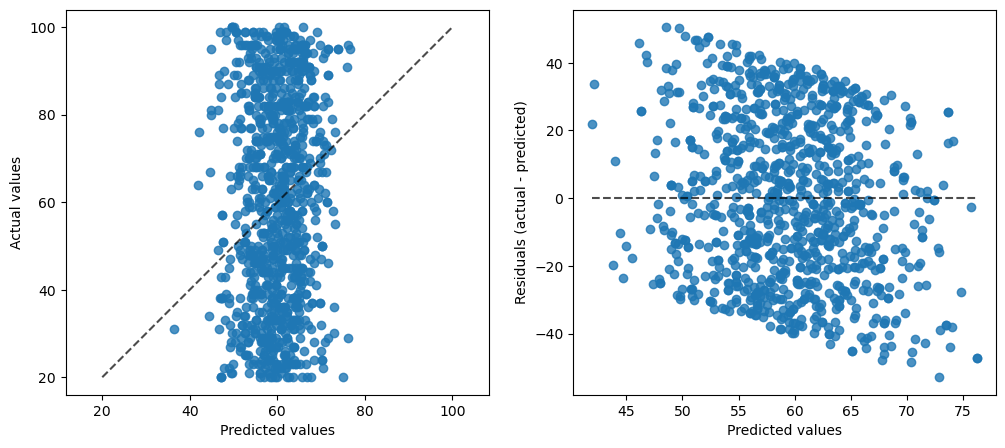

In [90]:
train_model(scaler,lr)

Our training model is:LinearRegression()
The training set score is: -0.05118971331048483
The test set score is: -0.06798414009268994
The R^2 score is: -0.06798414009268994
The Mean Absolute Error is: 20.597055299984937
The Mean Squared Error is: 588.6404980294298
The Max Error is: 56.831800767164694


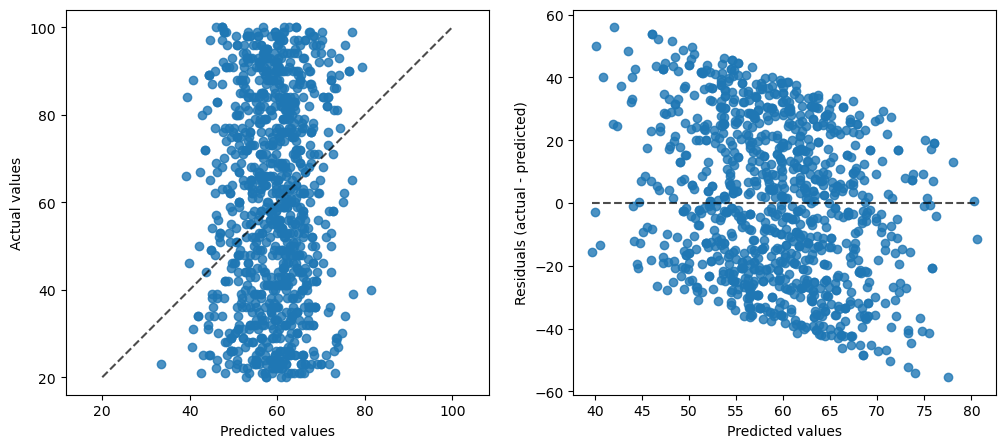

Our training model is:Ridge(alpha=0.5, random_state=4)
The training set score is: 0.01072914159425753
The test set score is: 0.004876886966145522
The R^2 score is: 0.004876886966145522
The Mean Absolute Error is: 20.2759255820106
The Mean Squared Error is: 548.48170760851
The Max Error is: 44.51355408574195


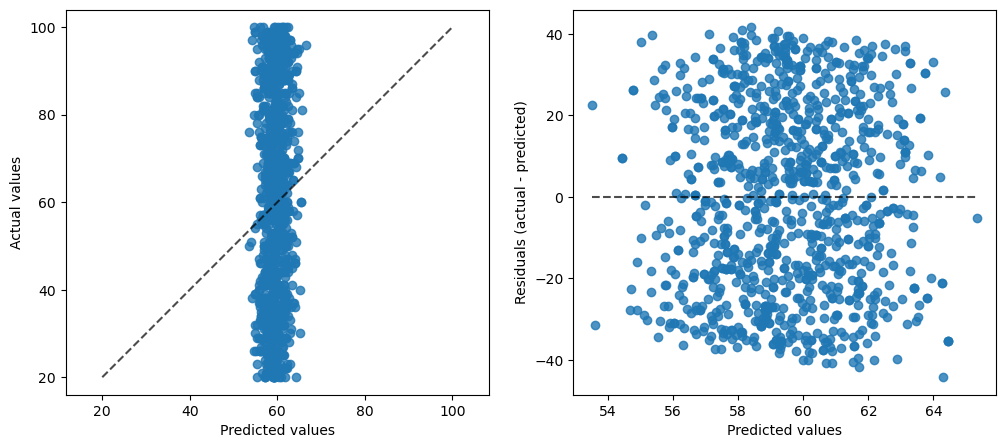

Our training model is:Lasso(alpha=0.5, random_state=4)
The training set score is: 0.007003640943190836
The test set score is: -0.0006553004442355626
The R^2 score is: -0.0006553004442355626
The Mean Absolute Error is: 20.311849050890498
The Mean Squared Error is: 551.5308816834698
The Max Error is: 41.07657817779284


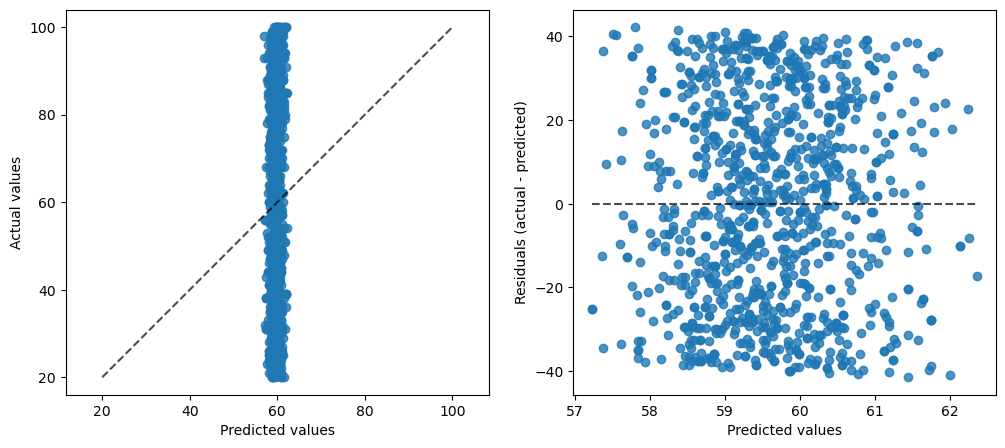

Our training model is:ElasticNet(random_state=4)
The training set score is: 0.007328929088309177
The test set score is: -0.0012866028507783067
The R^2 score is: -0.0012866028507783067
The Mean Absolute Error is: 20.304738803071295
The Mean Squared Error is: 551.8788364414518
The Max Error is: 41.47208260223219


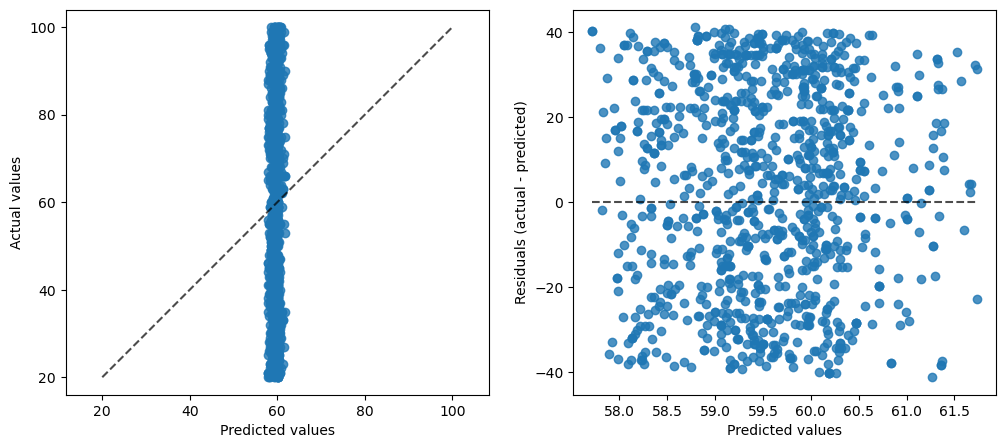

Our training model is:SVR()
The training set score is: 0.002136380999270826
The test set score is: -0.001763766672823408
The R^2 score is: -0.001763766672823408
The Mean Absolute Error is: 20.331594304328924
The Mean Squared Error is: 552.1418346820677
The Max Error is: 40.91641273040988


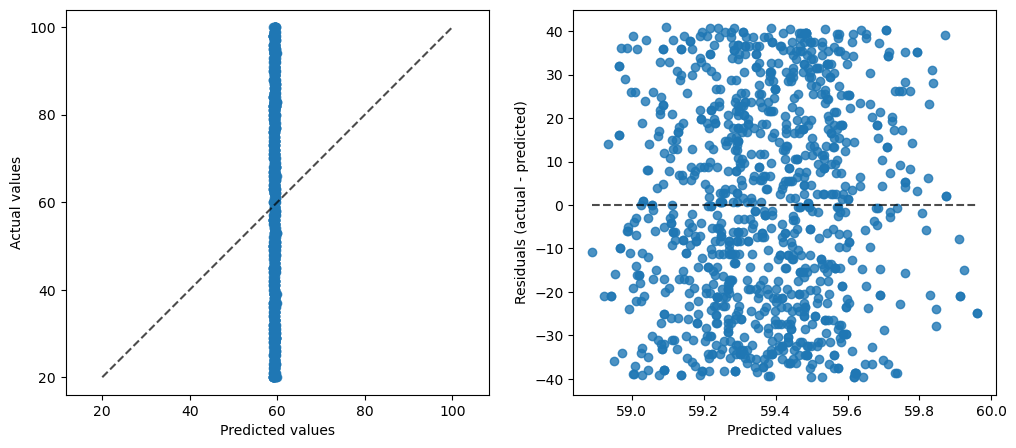

In [91]:
# Create loop to test all models

model_names = [lr, rd, ls, en, svr]
for name in model_names:
    print('Our training model is:' + str(name))
    train_model(scaler,name)